<a href="https://colab.research.google.com/github/akalakheti/ImagenetteS4TF/blob/master/Imagenette.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Swift for TensorFlow
In this notebook, we wil be training an image classification model on imagenette dataset which is a subset of ImageNet Dataset. It has a total of 10 classes.

In [0]:
%install '.package(url: "https://github.com/tensorflow/swift-models.git", .branch("master"))' Datasets

Installing packages:
	.package(url: "https://github.com/tensorflow/swift-models.git", .branch("master"))
		Datasets
With SwiftPM flags: []
Working in: /tmp/tmp9mjqzuy4/swift-install
Fetching https://github.com/tensorflow/swift-models.git
Fetching https://github.com/kylef/Commander.git
Fetching https://github.com/kylef/Spectre.git
Cloning https://github.com/tensorflow/swift-models.git
Resolving https://github.com/tensorflow/swift-models.git at master
Cloning https://github.com/kylef/Commander.git
Resolving https://github.com/kylef/Commander.git at 0.9.1
Cloning https://github.com/kylef/Spectre.git
Resolving https://github.com/kylef/Spectre.git at 0.9.0
[1/8] Compiling ModelSupport CheckpointReader.swift
[2/8] Compiling ModelSupport FileManagement.swift
[3/8] Compiling ModelSupport Image.swift
[4/8] Compiling ModelSupport Stderr.swift
[5/9] Merging module ModelSupport
[6/14] Wrapping AST for ModelSupport for debugging
[7/15] Compiling Datasets CIFAR10.swift
[8/15] Compiling Datasets Data

In [0]:
import TensorFlow
import ModelSupport
import Datasets

In [0]:
import Python
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")
let plt = Python.import("matplotlib.pyplot")
let np = Python.import("numpy")
let pil = Python.import("PIL")
let glob = Python.import("glob")

Downloading the dataset.

In [0]:
import Foundation
import FoundationNetworking
let subprocess = Python.import("subprocess")

In [0]:
let command = "wget -nv -O- https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz | tar xzf - -C ."
subprocess.call(command, shell: true)

2020-01-12 10:12:50 URL:https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz [98948031/98948031] -> "-" [1]


0


In [0]:
func dataPreps(name: String) -> LabeledExample{
  let wholeData = try! FileManager.default.contentsOfDirectory(atPath: "/content/imagenette2-160/\(name)/")
  var imageData: [Float] = []
  var labels: [Int32] = []
  var totalImages: Int = 0
  var label: Int32 = 0
  for folder in wholeData{
    let allImgPath = glob.glob("/content/imagenette2-160/\(name)/\(folder)/*.JPEG")
    
    
    for imagePath in allImgPath{
      let image = pil.Image.open(imagePath).convert("RGB")

      var img = np.array(image, dtype: np.float32) * (1.0 / 255)
      var imageTensor = Tensor<Float>(numpy: img)!
      
    
      imageTensor = imageTensor.expandingShape(at: 0)
      
      imageTensor = _Raw.resizeArea(images: imageTensor , size: [32, 32])
      labels.append(label)
      imageData.append(contentsOf: imageTensor.scalars)
      totalImages += 1
      
    }
    label += 1
  }
  let lbl = Tensor<Int32>(labels)
  let imageTns = Tensor<Float>(
        shape: [totalImages, 32, 32, 3], scalars: imageData)

  return LabeledExample(label: lbl, data: imageTns)
}


In [0]:
var trainingData = Dataset<LabeledExample>(
                elements: try! dataPreps(name:"train"))
var testingData = Dataset<LabeledExample>(
                elements: try! dataPreps(name:"val"))

Creating batches from test dataset. We will be creating training batches during the time of training.

In [0]:
let batchSize = 64
let testBatches = testingData.batched(batchSize)

This is the core of our program. In this block we create a skeleton of our model. We will be creating a Convolutional Neural Network as it best suits for image processing. There will be some dropout layers to prevent overfitting and the final layer i.e. output layer consists of 10 nodes representing 10 classes for prediction. 

In [0]:
let hiddenSize: Int = 10
let outputClasses: Int = 10
struct Classifier: Layer {
    typealias Input = Tensor<Float>
    typealias Output = Tensor<Float>

    var conv1a = Conv2D<Float>(filterShape: (3, 3, 3, 32), padding: .same, activation: relu)
    var conv1b = Conv2D<Float>(filterShape: (3, 3, 32, 32), activation: relu)
    var pool1 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2))
    var dropout1 = Dropout<Float>(probability: 0.25)
    var conv2a = Conv2D<Float>(filterShape: (3, 3, 32, 64), padding: .same, activation: relu)
    var conv2b = Conv2D<Float>(filterShape: (3, 3, 64, 64), activation: relu)
    var pool2 = MaxPool2D<Float>(poolSize: (2, 2), strides: (2, 2))
    var flatten = Flatten<Float>()
    var dense1 = Dense<Float>(inputSize: 64 * 6 * 6, outputSize: 512, activation: relu)
    var dropout3 = Dropout<Float>(probability: 0.5)
    var dense2 = Dense<Float>(inputSize: 512, outputSize: outputClasses, activation: identity)

    @differentiable
    func callAsFunction(_ input: Input) -> Output {
        let conv1 = input.sequenced(through: conv1a, conv1b, pool1, dropout1)
        let conv2 = conv1.sequenced(through: conv2a, conv2b, pool2)
        return conv2.sequenced(through: flatten, dense1, dropout3, dense2)
    }

}

Creating instance of our model class.

In [0]:
var model = Classifier()

Initializing optimizier for our model.

In [0]:
let optimizer = RMSProp(for: model, learningRate: 0.0001, decay: 1e-6)

Declaring number of epochs and lists for storing accuracy and loss per epoch for training.

In [0]:
let EPOCHS=40

var trainAccuracies: [Float] = []
var trainLosses: [Float] = []

var valAccuracies: [Float] = []
var valLosses: [Float] = []

In [0]:
func accuracy(predictions: Tensor<Float>, truths: Tensor<Int32>) -> Float {
    return Tensor<Float>(predictions.argmax(squeezingAxis: 1) .== truths).mean().scalarized()
}

Now, the actual training process starts. We will be calculating loss (softmaxCrossEntropy) and gradients of the model at each batch and then will be trying to minimize that loss using our optimizer (RMSProp). The training will be iterated over number of epochs we declared above. The accuracy metrics of the model is calculated on test set by comparing the predicted label vs groud truth. In this way, our model is trained.



In [0]:
for epoch in 1...EPOCHS {
  //Training the model
    Context.local.learningPhase = .training
    var totalTrainingLoss: Float = 0
    var trainingBatchCount = 0
    var totalTrainingAcc: Float = 0
    let shuffledData = trainingData.shuffled( sampleCount: 12894, randomSeed: Int64(epoch)).batched(batchSize)
    for batch in shuffledData {
        let (labels, images) = (batch.label, batch.data)
        let (loss, gradients) = valueWithGradient(at: model) { model -> Tensor<Float> in
            let logits = model(images)  //predicting the output from the model for tuning parameters.
            return softmaxCrossEntropy(logits: logits, labels: labels) //loss of the model.
        }
        let logits = model(images)
        totalTrainingLoss += loss.scalarized()
        totalTrainingAcc += accuracy(predictions:logits , truths:labels )

        trainingBatchCount += 1
        optimizer.update(&model, along: gradients)  //Minimizing the loss of model using optimizer.
    }

    let epoch_train_loss = totalTrainingLoss / Float(trainingBatchCount)
    let epoch_train_accuracy = totalTrainingAcc / Float(trainingBatchCount)
    
    trainAccuracies.append(epoch_train_accuracy)
    trainLosses.append(epoch_train_loss)
    
  //Testing the model
    Context.local.learningPhase = .inference
    var totalTestLoss: Float = 0
    var totalTestAcc: Float = 0
    var testBatchCount = 0
    for batch in testBatches {
        let (labels, images) = (batch.label, batch.data)
        let logits = model(images)
        totalTestLoss += softmaxCrossEntropy(logits: logits, labels: labels).scalarized()
        testBatchCount += 1
        totalTestAcc += accuracy(predictions:logits , truths: labels )
        
    }

    let epoch_val_accuracy = totalTestAcc / Float(testBatchCount)
    let epoch_val_loss = totalTestLoss / Float(testBatchCount)

    valAccuracies.append(epoch_val_accuracy)
    valLosses.append(epoch_val_loss)
    print(
        """
        [Epoch \(epoch)] \
        Train Accuracy: \(epoch_train_accuracy) \
        Train Loss: \(epoch_train_loss) \
        Val Accuracy: \(epoch_val_accuracy) \
        Val Loss: \(epoch_val_loss)
        """
    )
}

[Epoch 1] Train Accuracy: 0.23423135 Train Loss: 2.1435924 Val Accuracy: 0.3105799 Val Loss: 2.0049393
[Epoch 2] Train Accuracy: 0.31866312 Train Loss: 1.9639952 Val Accuracy: 0.3643313 Val Loss: 1.8933519
[Epoch 3] Train Accuracy: 0.3680771 Train Loss: 1.8480734 Val Accuracy: 0.40717405 Val Loss: 1.7797518
[Epoch 4] Train Accuracy: 0.40111148 Train Loss: 1.7510483 Val Accuracy: 0.4343918 Val Loss: 1.7102736
[Epoch 5] Train Accuracy: 0.4323303 Train Loss: 1.6884207 Val Accuracy: 0.44371638 Val Loss: 1.65095
[Epoch 6] Train Accuracy: 0.45054102 Train Loss: 1.6269472 Val Accuracy: 0.4671299 Val Loss: 1.5823374
[Epoch 7] Train Accuracy: 0.47051018 Train Loss: 1.5739545 Val Accuracy: 0.4704301 Val Loss: 1.5724517
[Epoch 8] Train Accuracy: 0.4852542 Train Loss: 1.5212193 Val Accuracy: 0.50345623 Val Loss: 1.5037397
[Epoch 9] Train Accuracy: 0.50388724 Train Loss: 1.4713345 Val Accuracy: 0.49941194 Val Loss: 1.4922185
[Epoch 10] Train Accuracy: 0.51777107 Train Loss: 1.4349606 Val Accuracy: 

Visualizing our training process.

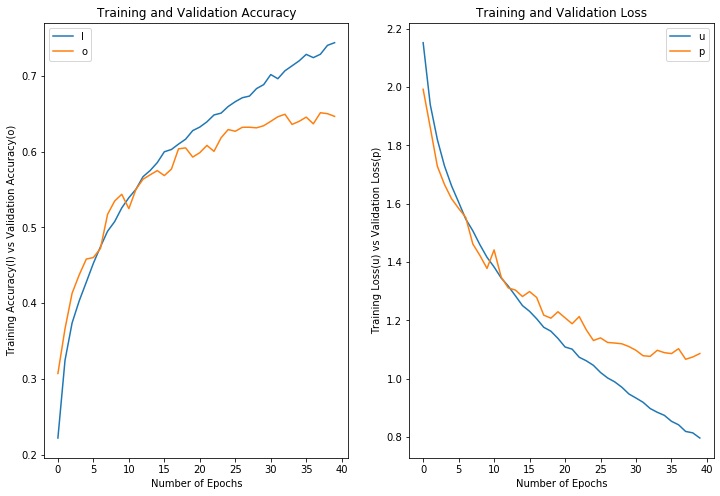

None


In [0]:
plt.figure(figsize: [12, 8])
plt.subplot(1, 2, 1)
plt.xlabel("Number of Epochs")
plt.ylabel("Training Accuracy(l) vs Validation Accuracy(o)")
plt.plot( trainAccuracies)
plt.plot( valAccuracies)
var loc = "lower right"
plt.legend(loc)
plt.title("Training and Validation Accuracy")

plt.subplot(1, 2, 2)
plt.xlabel("Number of Epochs")
plt.ylabel("Training Loss(u) vs Validation Loss(p)")
plt.plot(trainLosses)
plt.plot( valLosses)
loc = "upper right"
plt.legend(loc)
plt.title("Training and Validation Loss")
plt.show()


# Checking prediction from model
Now, we will choose a random image that falls under the label of CIFAR10 dataset. Here, let's choose a random image of deer. Now, a new function is created to convert the image to tensor and also normalizing and resizing the image according to model.

In [0]:
func image_to_tensor(path: String) -> (Tensor<Float>) {
    let img = pil.Image.open(path) // Open the image
    plt.imshow(img) // Plot the image before any other processing
    plt.show()

    var image = np.array(img, dtype: np.float32) * (1.0 / 255) //normalizing the image
    var imageTensor = Tensor<Float>(numpy: image)! //converting numpy array to tensor
    imageTensor = imageTensor.expandingShape(at: 0)
    imageTensor = _Raw.resizeArea(images: imageTensor , size: [32, 32]) //Resizing the image
    
    return imageTensor
}

Creating list of labels.

In [0]:
let classes:PythonObject  =  ["parachute", "golf ball","dog","truck","trumpet","building","person","radio","post box","fish"]

Running prediciton.

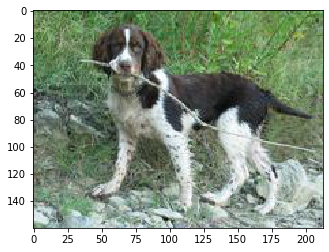

In [0]:
let img_tensor = image_to_tensor(path: "/content/imagenette2-160/train/n02102040/n02102040_5704.JPEG")
let pred = model(img_tensor)
let pred_idx = pred.argmax(squeezingAxis: 1).sum().scalarized()

In [0]:
print(classes[pred_idx])

dog


# Conclusion:
The model provided a decent result on Imagenette dataset as we can see in above plot. As we had reduced the image size to 32x32 due to lack of memory, it affected the model performance. It could have been better if we had trained the model on images with a bit higher size. Overall, the performance of model is good.